In [1]:
!pip install sklearn scipy matplotlib

  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


# Алгоритмы кластеризации

Задание на сегодня состоит из двух задач. Нужно реализовать алгоритмы k-means и иерархическую кластеризацию.

In [2]:
from google.colab import files
uploaded = files.upload()

Saving flower.png to flower.png


### 1. K-Means (1 балл)

Реализуйте метод сжатия изображений в формате PNG с помощью кластеризации пикселей.

Общая схема работы метода:

* С помощью алгоритма Ллойда построить по изображению набор из **K** базовых цветов. Базовый цвет – это центроид в пространстве RGB.

* Преобразовать исходное изображение в новое, в котором каждый пиксель заменен на ближайший к нему базовый цвет.

Необходимо, чтобы преобразованное изображение визуально не сильно отличалось от исходного

![image.png](attachment:0bd531ea-f39a-4ac8-a3a1-1b4ad7bcf9d1.png)

Алгоритм минимизирует функцию ошибки (**loss function**) вида

![image.png](attachment:c96ea3bd-fa0a-4b46-abab-958c7a824598.png)

Расстояние между точками евклидово

![image.png](attachment:e80fc4ba-152b-43df-9410-abd48d26adba.png)

In [3]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Для проверки критерия сходимости можно использовать функцию `np.allclose(x, y)`

In [4]:
np.allclose([[1,2,3], [1,2,3]], [[1,2,3], [1,2,2.95]], atol=0.01)

False

In [5]:
np.allclose([[1,2,3], [1,2,3]], [[1,2,3], [1,2,2.95]], atol=0.1)

True

#### Загрузка данных

In [6]:
# Загрузим картинку
img = plt.imread("flower.png")[:,:,:3]

# Теперь в переменной img находится трехмерный массив чисел.
print(img.shape)

(427, 640, 3)


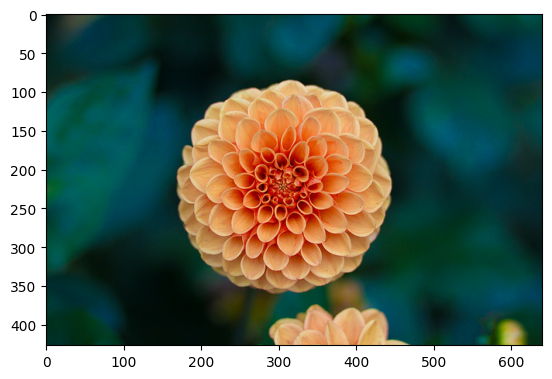

In [7]:
_ = plt.imshow(img)

In [8]:
# Цвет каждой точки задается трехмерным вектором в пространстве RGB. Это наши признаки.
print(img[400, 500])

[0.04313726 0.12156863 0.11372549]


In [9]:
# Преобразуем массив в двумерный. Теперь первая координата – номер точки, вторая – ее признаки
X = img.reshape((-1,3))
print(X.shape)

(273280, 3)


#### Кластеризация

Примерная структура класса. Можно менять, если хотите

In [10]:
from scipy.spatial import distance
import math

class KMeans(object):
    def __init__(self, n_clusters, max_iter, seed=0, tol=0.001):
        # число кластеров
        self.n_clusters = n_clusters
        # максимальное число итераций (на случай, если будет долго сходиться)
        self.max_iter = max_iter
        # array-like of shape (n_clusters, n_features) – в эту переменную сохраняются координаты центроидов
        self.centroids = None
        # массив со значениями функции ошибки на каждой итерации
        self.losses = []
        # зерно генератора случайных чисел
        self.seed = seed
        # точность, с которой мы смотрим на изменение положения центроидов
        self.tol = tol

    def euklid_dist(self, x, y):
      return math.sqrt(sum((x[i] - y[i]) ** 2 for i in range(len(x))))


    def distances(self, X):
        '''
        Returns distance from each sample to all centroids
        :param X: array-like of shape (n_samples, n_features)
            Training instances to cluster
        :return dist: array-like of shape (n_samples, n_clusters)
            Matrix of distances
        '''
        # your code goes here
        return distance.cdist(X, self.centroids)

    def loss(self, dist):
        '''
        :param dist: array-like of shape (n_samples, n_clusters)
            Matrix of distances
        :return loss: float
            Value of the loss function
        '''
        # your code goes here
        return np.mean(np.min(dist ** 2, axis=1))

    def initialize(self, X):
        '''
        Initialize centroids
        :param X: array-like of shape (n_samples, n_features)
            Training instances to cluster

        '''
        # your code goes here
        self.centroids = X[np.random.choice(len(X), self.n_clusters, replace=False)]


    def fit_predict(self, X):
        '''
        Implements Lloyd's algorithm
        :param X: array-like of shape (n_samples, n_features)
            Training instances to cluster
        :return labels : ndarray of shape (n_samples,)
            Index of the cluster each sample belongs to.
        '''
        # инициализируем генератор случайных чисел
        np.random.seed(self.seed)

        # инициализируем центроиды
        self.initialize(X)

        # your code goes here
        labels = []
        for _ in range(self.max_iter):
          labels = [0 for _ in range(len(X))]
          distances = self.distances(X)
          labels = np.argmin(distances, axis=1)
          new_centroids = np.array([X[labels == k].mean(axis = 0) for k in range(self.n_clusters)])
          if np.allclose(self.centroids, new_centroids, atol=self.tol):
            break
          self.centroids = new_centroids.copy()
          self.losses.append(self.loss(distances))
        return labels

Запустим кластеризацию на наших данных

In [37]:
cls = KMeans(n_clusters=8, max_iter=100, seed=1)
y_pred = cls.fit_predict(X)
losses = cls.losses
centroids = cls.centroids

Посмотрим, как убывала функция ошибки

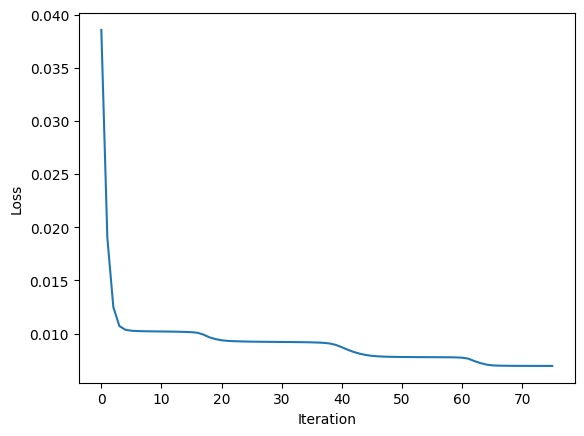

In [39]:
_ = plt.plot(losses)
_ = plt.xlabel('Iteration')
_ = plt.ylabel('Loss')

Наши центроиды – цвета в пространстве RGB. Можно их нарисовать

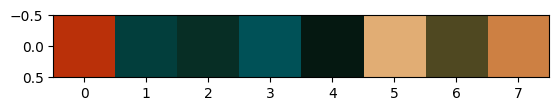

In [40]:
_ = plt.imshow([centroids])

Теперь сделайте из `X` матрицу `Y`, в которой координаты каждой точки заменены на координаты центроида

In [41]:
Y = [cls.centroids[i] for i in y_pred]

Посмотрим, что получилось

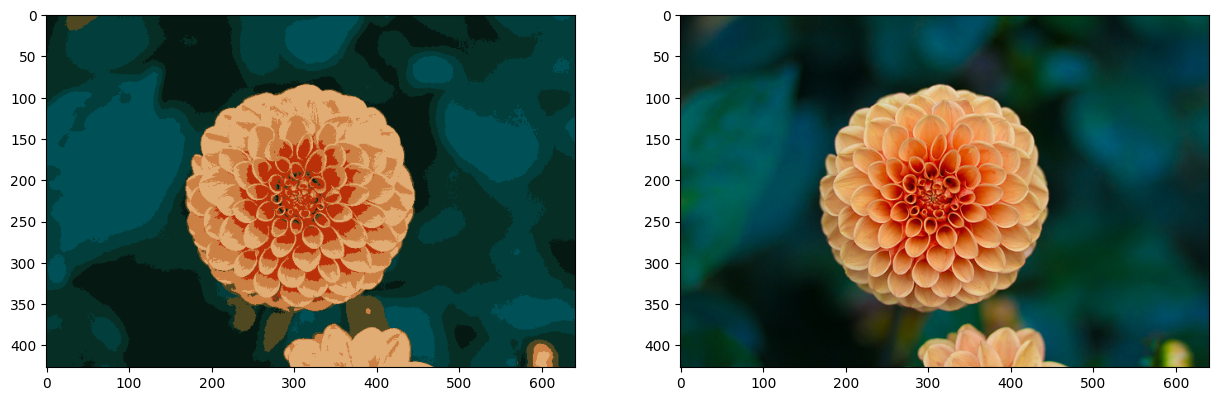

In [42]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,15))
_ = ax1.imshow(np.array(Y).reshape(img.shape))
_ = ax2.imshow(img)

Поэкспериментируйте с разным числом кластеров

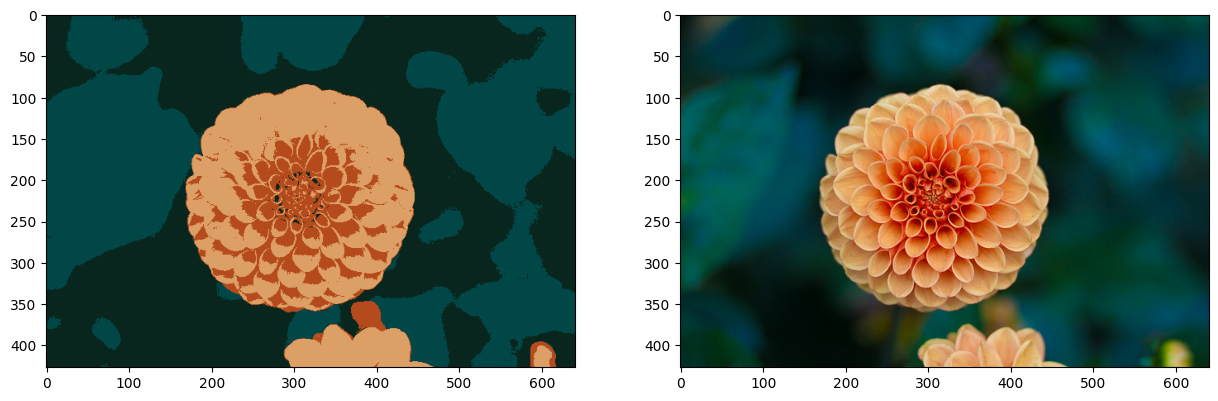

In [16]:
cls = KMeans(n_clusters=4, max_iter=100, seed=0)
y_pred = cls.fit_predict(X)
losses = cls.losses
centroids = cls.centroids

Y = centroids[y_pred, :]

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,15))
_ = ax1.imshow(np.array(Y).reshape(img.shape))
_ = ax2.imshow(img)

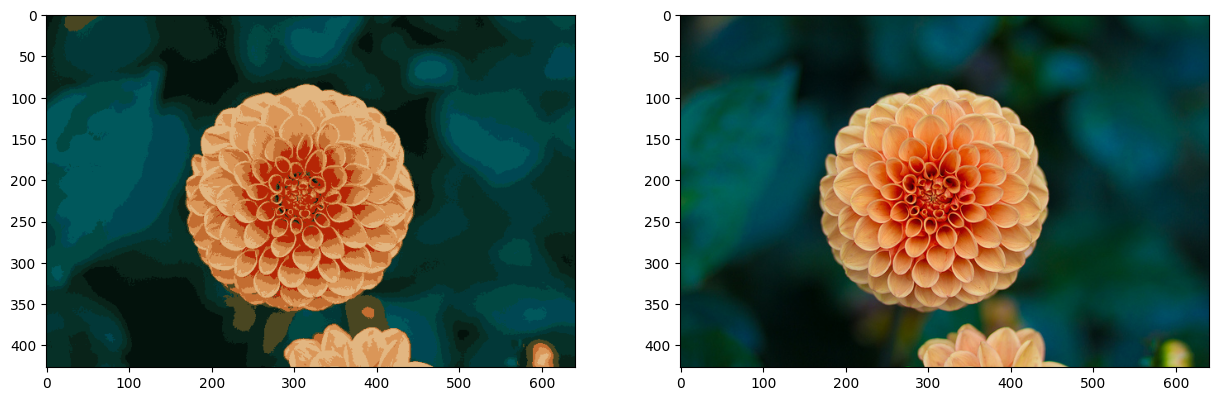

In [17]:
cls = KMeans(n_clusters=12, max_iter=100, seed=0)
y_pred = cls.fit_predict(X)
losses = cls.losses
centroids = cls.centroids

Y = centroids[y_pred, :]

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,15))
_ = ax1.imshow(np.array(Y).reshape(img.shape))
_ = ax2.imshow(img)

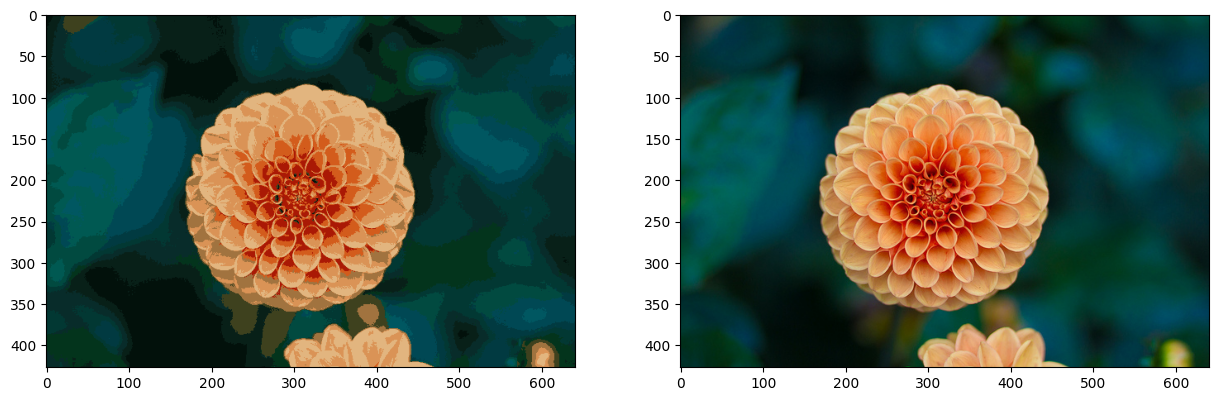

In [18]:
cls = KMeans(n_clusters=16, max_iter=100, seed=0)
y_pred = cls.fit_predict(X)
losses = cls.losses
centroids = cls.centroids

Y = centroids[y_pred, :]

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,15))
_ = ax1.imshow(np.array(Y).reshape(img.shape))
_ = ax2.imshow(img)

### 2. Иерархическая кластеризация (1 балл)

Реализуйте алгоритм иерархической кластеризации

![image.png](attachment:9e614661-48df-4408-883f-959e7669c6b3.png)

Для вычисления расстояний между кластерами используйте среднее расстояние между входящими в них точками:

![image.png](attachment:3dafa13a-e894-4730-aa6c-a80ddbbd70f7.png)



#### 2.1. Реализуйте функцию `distance_matrix`, вычисляющую матрицу попарных расстояний между точками.
В качестве метрики мы будем использовать евклидово расстояние,

![image.png](attachment:a96735b3-7330-40aa-8437-fd65967cb228.png)


In [19]:
def distance_matrix(X):
    '''
    Compute matrix of pair-wise distances between samples
    :param X: array-like of shape (n_samples, n_features)
        Samples
    :return D: array-like of shape (n_samples, n_samples)
        Matrix of pair-wise distances between samples
    '''
    D = distance.squareform(distance.pdist(X))

    return D

#### 2.2. Реализуйте функцию `linkage`.

На вход подается матрица расстояний. На выходе – результат кластеризации в виде матрицы связей. Строки этой матрицы соответствуют операции объединения кластеров. Каждая строка имеет вид

```[C1, C2, dist(C1, C2), N]```

где `C1` и `C2` – номера объединяемых кластеров, `dist(C1, C2)` – расстояние между объединяемыми кластерами, `N` – число точек в новом кластере

Например, кластеризации

![image.png](attachment:21e3a50a-5bc0-4525-ab8d-223403a765fc.png)

соответствует
```
Z = [[ 3.    5.    0.43  2.  ]
     [ 4.    6.    0.55  2.  ]
     [ 2.    7.    0.66  3.  ]
     [ 0.    1.    0.74  2.  ]
     [ 8.    9.    0.82  5.  ]
     [10.   11.    1.12  7.  ]]
```


In [20]:
class Cluster(object):
  def __init__(self, elements, number):
    self.elements = elements
    self.number = number

In [21]:
def dist_between_clusters(C1, C2, D):
  return np.mean([D[i][j] for i in C1.elements for j in C2.elements])

In [22]:
def find_min_clusters(D):
  pair = None
  min_v = float('inf')
  for i in range(len(D)):
    for j in range(i+1, len(D)):
      if D[i][j] < min_v:
        min_v = D[i][j]
        pair = (i, j)
  return pair

In [23]:
def linkage(D):
    '''
    :param D: array-like of shape (n_samples, n_samples)
            Matrix of pair-wise distances between samples
    :return linkage: Linkage matrix
    '''
    n = len(D)
    D1 = D.copy()
    linkage = []
    clusters = [Cluster([i], i) for i in range(n)]
    active = list(range(n))
    clusters_index = n

    while len(clusters) > 1:
      c1_ind, c2_ind = find_min_clusters(D1)
      C1, C2 = clusters[c1_ind], clusters[c2_ind]
      C = Cluster(C1.elements + C2.elements, clusters_index)
      linkage.append([C1.number, C2.number, dist_between_clusters(C1, C2, D), len(C.elements)])

      if len(clusters) == 2:
        break

      for i in range(len(D1)):
         if i != c1_ind and i != c2_ind:
          D1[c1_ind, i] = D1[i, c1_ind] = dist_between_clusters(C, clusters[i], D)

      D1 = np.delete(D1, c2_ind, axis=0)
      D1 = np.delete(D1, c2_ind, axis=1)
      del clusters[c2_ind]
      clusters[c1_ind] = C
      clusters_index += 1

    return linkage

####  Проверка 1

In [24]:
# Нам дана матрица расстояний
D = np.array([[0.  , 0.74, 0.85, 0.54, 0.83, 0.92, 0.89],
              [0.74, 0.  , 1.59, 1.35, 1.2 , 1.48, 1.55],
              [0.85, 1.59, 0.  , 0.63, 1.13, 0.69, 0.73],
              [0.54, 1.35, 0.63, 0.  , 0.66, 0.43, 0.88],
              [0.83, 1.2 , 1.13, 0.66, 0.  , 0.72, 0.55],
              [0.92, 1.48, 0.69, 0.43, 0.72, 0.  , 0.8 ],
              [0.89, 1.55, 0.73, 0.88, 0.55, 0.8 , 0.  ]])

# кластеризуем
Z = linkage(D)

# и напечатаем что получилось
print(np.array(Z))

[[ 3.    5.    0.43  2.  ]
 [ 4.    6.    0.55  2.  ]
 [ 2.    7.    0.66  3.  ]
 [ 0.    1.    0.74  2.  ]
 [ 9.    8.    0.82  5.  ]
 [10.   11.    1.12  7.  ]]


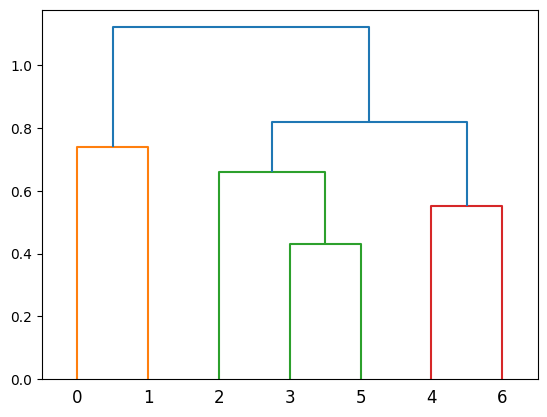

In [25]:
# для построения дендрограммы воспользуемся функцией из библиотеки scipy
from scipy.cluster.hierarchy import dendrogram

# должна получиться картинка из начала этого раздела
_ = dendrogram(Z)

####  Проверка 2

In [26]:
D = np.array([
    [0.  , 0.43, 0.93, 0.85, 0.94, 0.7 , 0.95, 0.79, 0.89, 1.34, 0.8 , 0.64, 1.42, 1.37, 0.86, 1.2 , 0.49, 0.19, 1.48, 0.86],
    [0.43, 0.  , 0.66, 0.7 , 1.48, 0.58, 0.7 , 0.55, 0.68, 1.45, 1.31, 0.37, 1.24, 1.69, 0.91, 1.28, 1.04, 0.29, 0.94, 1.05],
    [0.93, 0.66, 0.  , 1.01, 1.42, 0.8 , 0.76, 1.18, 0.21, 1.18, 1.35, 0.82, 0.68, 0.85, 0.75, 1.01, 0.93, 1.03, 0.6 , 0.91],
    [0.85, 0.7 , 1.01, 0.  , 1.02, 0.22, 0.89, 0.91, 0.79, 1.47, 1.04, 1.51, 0.71, 1.63, 0.34, 1.05, 1.24, 0.56, 1.09, 1.25],
    [0.94, 1.48, 1.42, 1.02, 0.  , 1.46, 1.48, 0.95, 1.44, 1.08, 0.3 , 1.29, 1.28, 0.65, 1.  , 0.8 , 0.8 , 0.92, 1.48, 0.65],
    [0.7 , 0.58, 0.8 , 0.22, 1.46, 0.  , 0.77, 1.  , 0.65, 1.25, 1.27, 1.36, 0.81, 1.56, 0.37, 0.98, 1.17, 0.68, 0.88, 1.23],
    [0.95, 0.7 , 0.76, 0.89, 1.48, 0.77, 0.  , 1.41, 1.08, 1.61, 1.65, 0.89, 0.76, 1.32, 0.64, 0.7 , 0.59, 1.07, 0.49, 0.91],
    [0.79, 0.55, 1.18, 0.91, 0.95, 1.  , 1.41, 0.  , 1.05, 0.73, 1.08, 0.7 , 1.49, 1.17, 1.  , 1.34, 1.45, 0.49, 1.06, 1.3 ],
    [0.89, 0.68, 0.21, 0.79, 1.44, 0.65, 1.08, 1.05, 0.  , 0.96, 1.09, 0.94, 0.44, 1.06, 0.9 , 1.47, 1.2 , 0.79, 1.04, 1.39],
    [1.34, 1.45, 1.18, 1.47, 1.08, 1.25, 1.61, 0.73, 0.96, 0.  , 0.96, 1.1 , 1.05, 0.48, 1.36, 1.26, 1.38, 1.38, 1.03, 1.38],
    [0.8 , 1.31, 1.35, 1.04, 0.3 , 1.27, 1.65, 1.08, 1.09, 0.96, 0.  , 1.08, 1.09, 0.79, 1.4 , 1.03, 1.02, 0.78, 1.79, 0.86],
    [0.64, 0.37, 0.82, 1.51, 1.29, 1.36, 0.89, 0.7 , 0.94, 1.1 , 1.08, 0.  , 1.42, 1.2 , 1.61, 1.3 , 0.86, 0.68, 1.04, 0.83],
    [1.42, 1.24, 0.68, 0.71, 1.28, 0.81, 0.76, 1.49, 0.44, 1.05, 1.09, 1.42, 0.  , 0.99, 0.84, 1.2 , 1.21, 1.22, 0.97, 1.58],
    [1.37, 1.69, 0.85, 1.63, 0.65, 1.56, 1.32, 1.17, 1.06, 0.48, 0.79, 1.2 , 0.99, 0.  , 1.13, 0.61, 1.  , 1.6 , 0.81, 0.83],
    [0.86, 0.91, 0.75, 0.34, 1.  , 0.37, 0.64, 1.  , 0.9 , 1.36, 1.4 , 1.61, 0.84, 1.13, 0.  , 0.68, 0.89, 0.86, 0.65, 1.04],
    [1.2 , 1.28, 1.01, 1.05, 0.8 , 0.98, 0.7 , 1.34, 1.47, 1.26, 1.03, 1.3 , 1.2 , 0.61, 0.68, 0.  , 0.92, 1.47, 0.47, 0.42],
    [0.49, 1.04, 0.93, 1.24, 0.8 , 1.17, 0.59, 1.45, 1.2 , 1.38, 1.02, 0.86, 1.21, 1.  , 0.89, 0.92, 0.  , 0.9 , 1.18, 0.49],
    [0.19, 0.29, 1.03, 0.56, 0.92, 0.68, 1.07, 0.49, 0.79, 1.38, 0.78, 0.68, 1.22, 1.6 , 0.86, 1.47, 0.9 , 0.  , 1.56, 1.21],
    [1.48, 0.94, 0.6 , 1.09, 1.48, 0.88, 0.49, 1.06, 1.04, 1.03, 1.79, 1.04, 0.97, 0.81, 0.65, 0.47, 1.18, 1.56, 0.  , 0.84],
    [0.86, 1.05, 0.91, 1.25, 0.65, 1.23, 0.91, 1.3 , 1.39, 1.38, 0.86, 0.83, 1.58, 0.83, 1.04, 0.42, 0.49, 1.21, 0.84, 0.  ]])

Выведите Linkage матрицу и постройте дендрограмму

[[ 0.         17.          0.19        2.        ]
 [ 2.          8.          0.21        2.        ]
 [ 3.          5.          0.22        2.        ]
 [ 4.         10.          0.3         2.        ]
 [22.         14.          0.355       3.        ]
 [20.          1.          0.36        3.        ]
 [15.         19.          0.42        2.        ]
 [ 9.         13.          0.48        2.        ]
 [ 6.         18.          0.49        2.        ]
 [21.         12.          0.56        3.        ]
 [25.         11.          0.56333333  4.        ]
 [30.          7.          0.6325      5.        ]
 [26.         16.          0.705       3.        ]
 [28.         32.          0.78166667  5.        ]
 [29.         24.          0.80666667  6.        ]
 [23.         27.          0.87        4.        ]
 [31.         34.          0.995      11.        ]
 [36.         33.          1.05890909 16.        ]
 [37.         35.          1.184375   20.        ]]


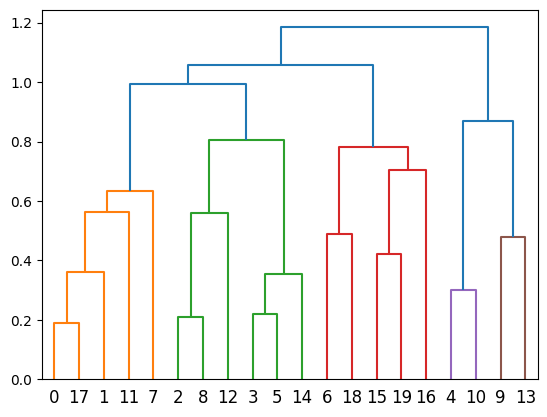

In [27]:
# your code here
Z = linkage(D)
print(np.array(Z))
_ = dendrogram(Z)

#### 2.3. Digits dataset

In [28]:
from sklearn import datasets

# загрузим датасет Digits. Он состоит из рукописных изображений цифр
digits = datasets.load_digits().images

In [29]:
# выберем 20 случайных изображений
digits = np.random.permutation(digits)[:20]

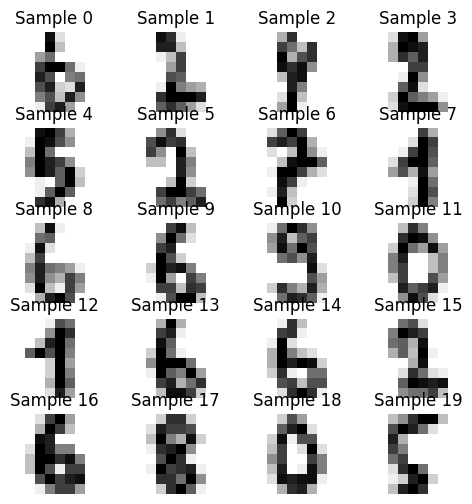

In [30]:
# вот они
_, axes = plt.subplots(nrows=5, ncols=4, figsize=(6, 6))
for i, (ax, image) in enumerate(zip(axes.flatten(), digits)):
    ax.set_axis_off()
    ax.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    ax.set_title(f'Sample {i}')

In [31]:
# каждое изображение – матрица размера (8, 8). Давайте вытянем ее в вектор признаков
XX = digits.reshape((digits.shape[0], -1))

**Кластеризуйте вектора и постройте дендрограмму. Какие выводы можно из нее сделать?**

[[ 7.         12.         18.86796226  2.        ]
 [13.         14.         20.19900988  2.        ]
 [ 9.         16.         21.11871208  2.        ]
 [11.         18.         23.2594067   2.        ]
 [ 5.         15.         23.72762104  2.        ]
 [ 8.         21.         24.30265508  3.        ]
 [25.         22.         30.24403727  5.        ]
 [ 1.         24.         30.83956277  3.        ]
 [ 0.         26.         37.37117013  6.        ]
 [27.          3.         37.49412877  4.        ]
 [28.         17.         38.53974318  7.        ]
 [10.         23.         38.88139121  3.        ]
 [30.          4.         44.66046391  8.        ]
 [32.         31.         45.07692201 11.        ]
 [29.          2.         45.50525285  5.        ]
 [33.         34.         48.99860169 16.        ]
 [35.         20.         53.13832133 18.        ]
 [36.          6.         53.72369984 19.        ]
 [37.         19.         54.32783542 20.        ]]


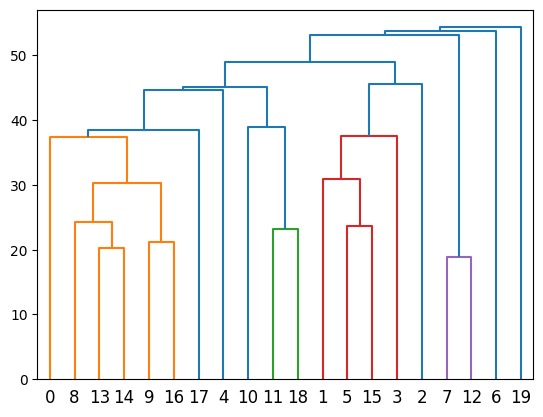

In [32]:
# your code here
D = distance_matrix(XX)
Z = linkage(D)
print(np.array(Z))
_ = dendrogram(Z)

**Выводы:**


Из дендрограммы видно, какие картинки изображают одинаковые цифры. Например, 0, 8, 13, 14, 9, 16 - это шестерка. 1, 5, 15, 3 - двойка. В целом иерархическая кластеризация правильно раличает рукописыне цифры по группам. Голубым цветом отмечены связи между наиболее похожими друг на друга цифрами(6 и 8). Цветным - картинки одной цифры.